# Predicting Goals Probability

Expected goals (xG) provides a measure of how likely a goal is to be scored, based on the location of the shot and other pertinent features. Similar to the in-game win probability predictor, it provides a probabilistic output. It is again assessed using Log Loss as an evaluation metric, and similar model classes are compared. The exception in this case is that an XGBoost model is added, as this model is commonly used in other publically available xG models. Therefore, the model classes investigated are:

- Logistic Regression
- Naive Bayes
- XGBoost
- Neural Network

Unfortunately, publically available shot data for the NHL is extremely limited. One of the most notable factors missing from this data is puck movement prior to the shot (i.e. pre-shot passing). This has been tracked by [Corey Sznajder](https://www.allthreezones.com/), but is only available through a subscription. Perhaps this will be added in a future version.

A two-part model was explored, but did not work. The idea was that some features are recorded for shots on net, but not for misses and blocks (eg. shot type). Therefore, the idea was to use a subset of the features to first determine the probability the shot would be on net (i.e. not a block or miss), then predict the conditional probability that the shot results in a goal. Unfortunately, since the additional data that would be used to improve the goal prediction performance does not exist for misses and blocks, this two-part model cannot be used to predict whether any shot will result in a goal (the absence of a shot type feature biases the miss prediction model). However, the probability of blocks and misses may still be added later as a prior factor, either as a constant or based on a simple condition, for example, as a function of distance from the net.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from datetime import timedelta, datetime
from scipy.stats import kurtosis

# from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
from xgboost import XGBClassifier

from models.common_sql import create_db_connection, select_table, sql_select
from models.common import binary_encoder
from models.common_plot import plot_calibration_curves
from models.common_torch import RegressionNN, CustomDataset, train_loop
from nhl_api.ref_common import game_time_to_sec


# Preprocessing

## Feature Selection

The list of features used to train the model are listed below. These include the play-by-play features that all publically available xG models commonly use. However, I also pulled features describing the shooter from the player data. For example, I have included the age and position of the player, in an attempt to improve model performance. The idea here is that more experienced players may score more efficiently, and that there may be a significant difference in scoring ability between forwards and defencemen. Additionally, I have engineered a feature describing whether the last event was a turnover, as turnovers can often lead to quick goals. In the future, I would like to weight this turnover variable, as well as the angle_change and delta_y features, by the time since the last event occurred. Previous events should only be relevant if they occurred relatively recently. However, the model may already learn this relationship, as the information exists implicitly in the current feature set.

Shots from outside the blueline and directly behind the net (<138 degrees from the centerline of the ice) are excluded, as they generally are not intended to score. Therefore, if they go in, it does not reflect an intentional outcome (and are not useful in predicting player impact later). However, shots from behind the goal line are kept, as these shots require a degree of skill and/or intelligence. Note however, that shots from this angle have a much greater chance of missing the net, and may not necessarily be recorded as a miss, so this may affect the data for these shots.

Blocks are removed because the coordinates correspond to the location of the block, not the shot location.

Removing shots from outside the blueline should automatically remove all shots made by goalies. However, 6 goaltender shots remained. This indicates that not all of the coordinate errors were caught by the reformatting. Unfortunately, there is no way to identify these remaining coordinate errors without going through each individual shot. 

List of features:
- net_distance: int = distance from shot to center of net (feet)
- net_angle: float = angle between center of net and shot (degrees)
- time_since_last: int = time elapsed since the last event (seconds)
- delta_y: int = change in y-direction (laterally) between shot and last event (feet)
- angle_change: float = change in angle between shot and last event (degrees)
- team_lead: int = number of goals the shooting team is leading by (negative if losing)
- game_time: int = current time in the game (seconds)
- player_age: float = age of player at time of the shot (days)
- rebound_shot: bool = whether previous event was a shot occurring within the last 3 seconds
- shooter_home: bool = whether the shooter plays for the home team
- shooter_hand: bool = whether the shooter is right- (1/True) or left-handed (0/False)
- shooter_position: bool = whether the shooter is a forward (1/True) or defence (0/False)
- off_wing_shot: bool = whether the shooter is taking the shot from their off-wing
- last_event_turnover: bool = whether the last event was a turnover

Target variable:
- goal: bool = whether the shot resulted in a goal

Other potential features:
- shooter height
- shooter weight
- angle_change * (1 / time_since_last)
- delta_y * (1 / time_since_last)

Features to include in a more complex (iterative) version in the future:
- player types on ice
- player impact scores on ice
- player on ice shooting %
- defensive strength against
- offensive strength for

## Game State Separation

Shots are separated by the game state in which they occur. This is justified by the game state analysis, which can be found in analyses/shots_eda.ipynb. However, it should be intuititve that the conditions determining whether a goal is scored are highly dependent on the game state. For example, in 3-on-3 play, there is much more room for players to create more high danger scoring chances, and for plays to develop faster. Shots are divided into three even strength game states: 5-on-5, 4-on-4, 3-on-3; two power play game states: 5-on-4, 5-on-3; and a single penalty kill game state X-on-5. Shots occurring at 4-on-3 and 3-on-4 are removed due to limited data. Shots with an empty net are also excluded as there is a high degree of variability associated with these events. Note that 3-on-3 would have a severly limited amount of data, if it were not for 3-on-3 overtime in the regular season. Here, the model is selected based on the most difficult game state to predict, even strength 5-on-5.

## Engineered Features

The time and score of the game are known to have an effect on shot accumulation. In general, the trailing team will push to score more and will take more shots on net. This is known as "score effects". Therefore, team_lead and game_time are features commonly occurring in many expected goal models. Additionally, turnovers can often lead quickly to a goal, so I included a boolean feature indicating whether the last event was a turnover. In the future, this may be scaled by how much time passes before the subsequent shot, or may be recorded only when the turnover was recent (however choosing a cutoff for what defines "recent" is another issue in this case).

All of the publically available expected goal models I have found only use the play-by-play data provided from a single NHL.com API endpoint. I believe the model performance can be improved by including additional information about the player. For example, perhaps players with more experience are more efficient in their scoring, or maybe there is a difference in shooting talent between forwards and defencemen? These features are included, in the hope that my model gains some advantage over other existing models.


In [2]:
# Create the database connection
connection = create_db_connection('postgres', 'marshineer', 'localhost', '5432', 'password')

# https://stackoverflow.com/questions/3492904/mysql-select-all-columns-from-one-table-and-some-from-another-table
# https://www.sqlshack.com/sql-multiple-joins-for-beginners-with-examples/
# https://www.w3schools.com/sql/sql_join.asp
sql_query = """SELECT shots.*, players.birth_date, players.position2, players.rookie_season, players.full_name, games.datetime
               FROM shots
               LEFT JOIN players ON shots.shooter_id = players.player_id
               LEFT JOIN games ON shots.game_id = games.game_id"""

cols = ['game_id', 'shot_id', 'shooter_id', 'shot_type', 'shot_result',
        'period', 'period_time', 'home_team_id', 'away_team_id', 'home_score', 
        'away_score', 'x_coord', 'y_coord', 'net_distance', 'net_angle',
        'rebound_shot', 'last_event_type', 'time_since_last', 'last_x_coord',
        'last_y_coord', 'delta_y', 'angle_change', 'play_ends', 'puck_frozen',
        'goal', 'missed', 'blocked', 'empty_net', 'shooter_home', 'shooter_hand',
        'off_wing_shot', 'players_home', 'players_away', 'shooter_birth_date',
        'shooter_position', 'shooter_rookie_season', 'shooter_name', 'game_datetime']
shots_df = sql_select(connection, sql_query, cols=cols)
print(shots_df.columns.tolist())
print(shots_df.shooter_position.unique().tolist())
print(shots_df.last_event_type.unique().tolist())
print(shots_df.shot_result.unique().tolist())
print(shots_df.shot_type.unique().tolist())

# Sort the shots data
shots_df.sort_values(['game_id', 'shot_id'], inplace=True)
shots_df.reset_index(drop=True, inplace=True)

# Load the player data as a dictionary
players_df = select_table(connection, 'players')
# players_df = pd.read_csv('~/Hockey-Analytics/data/players.csv')
print(players_df.columns.tolist())
players_list = players_df.to_dict('records')
players = {player_x['player_id']: player_x for player_x in players_list}


['game_id', 'shot_id', 'shooter_id', 'shot_type', 'shot_result', 'period', 'period_time', 'home_team_id', 'away_team_id', 'home_score', 'away_score', 'x_coord', 'y_coord', 'net_distance', 'net_angle', 'rebound_shot', 'last_event_type', 'time_since_last', 'last_x_coord', 'last_y_coord', 'delta_y', 'angle_change', 'play_ends', 'puck_frozen', 'goal', 'missed', 'blocked', 'empty_net', 'shooter_home', 'shooter_hand', 'off_wing_shot', 'players_home', 'players_away', 'shooter_birth_date', 'shooter_position', 'shooter_rookie_season', 'shooter_name', 'game_datetime']
['D', 'F', 'G']
['GIVEAWAY', 'BLOCK', 'SHOT', 'HIT', 'TAKEAWAY', 'MISS', 'FACEOFF', 'GOAL', 'STOP', 'PENALTY']
['BLOCK', 'SHOT', 'MISS', 'GOAL']
[None, 'WRIST', 'SNAP', 'TIP', 'WRAP', 'SLAP', 'BACKHAND', 'DEFLECT', 'OTHER']
['player_id', 'full_name', 'birth_date', 'nationality', 'position', 'position2', 'rookie_season', 'shoots_catches', 'height_cm', 'weight_kg']


In [3]:
# Remove rows where the shift data contained errors
too_few_players = shots_df[shots_df.players_home.apply(lambda x: len(eval(x)) < 4) & shots_df.players_away.apply(lambda x: len(eval(x)) < 4)]
too_many_players = shots_df[shots_df.players_home.apply(lambda x: len(eval(x)) > 6) | shots_df.players_away.apply(lambda x: len(eval(x)) > 6)]
print(f'Number of shift error entries = {len(too_few_players) + len(too_many_players)}')
shots_df = shots_df[shots_df.players_home.apply(lambda x: len(eval(x)) >= 4) & shots_df.players_away.apply(lambda x: len(eval(x)) >= 4) & 
                    shots_df.players_home.apply(lambda x: len(eval(x)) <= 6) & shots_df.players_away.apply(lambda x: len(eval(x)) <= 6)]

# Remove rows with nan/null shot distance or angle
print(f'Number of shots with no distance info = {len(shots_df[shots_df.net_distance.isna() | shots_df.net_angle.isna()])}')
shots_df.dropna(subset=['net_distance', 'net_angle'], inplace=True)
shots_df.reset_index(drop=True, inplace=True)

# Remove rows with nan/null previous shot coordinates
print(f'Number of shots with no previous event location info = {len(shots_df[shots_df.angle_change.isna() | shots_df.delta_y.isna()])}')
shots_df.dropna(subset=['angle_change', 'delta_y'], inplace=True)
shots_df.reset_index(drop=True, inplace=True)

# Remove blocks
block_mask = shots_df.shot_result == 'BLOCK'
blocks_df = shots_df.loc[block_mask]
blocks_df.reset_index(drop=True, inplace=True)
block_list = blocks_df.to_dict('records')
thru_prob = 1 - (sum(block_mask) / len(shots_df))  # Assumes all shots have an equal chance of being blocked
print(f'Number of shots that are blocked = {len(block_mask)} ({100 * (1 - thru_prob):4.2f}% of all shots)')
shots_df.drop(shots_df.loc[block_mask].index, inplace=True)
shots_df.reset_index(drop=True, inplace=True)

# # Remove misses
# shots_df = shots_df.loc[shots_df.shot_result.isin(['SHOT', 'GOAL'])]
# miss_mask = shots_df.shot_result == 'MISS'
# print(f'Number of shots that miss the net = {len(miss_mask)} ({100 * len(miss_mask) / len(shots_df):4.2f}% of all shots)')
# shots_df.reset_index(drop=True, inplace=True)

# # Remove the empty net goals
# print(f'Number of goals on empty nets = {len(shots_df[shots_df.empty_net == True])} '
#       f'({100 * len(shots_df[shots_df.empty_net == True]) / len(shots_df[shots_df.shot_result == "GOAL"]):4.2f}% of all goals)')
# shots_df.drop(shots_df[shots_df.empty_net == True].index, inplace=True)
# shots_df.reset_index(drop=True, inplace=True)

# Remove all shots that come from outside the blueline, as these are never intended to go in
# Indirectly removes goalie shots (or it should at least)
long_mask = (((shots_df.period % 2 == 1) ^ (shots_df.shooter_home == True)) & (shots_df.x_coord < 25)) | \
    (~((shots_df.period % 2 == 1) ^ (shots_df.shooter_home == True)) & (shots_df.x_coord > -25))
print(f'Number of shots from outside the blueline = {sum(long_mask)} ({100 * sum(long_mask) / len(shots_df):4.2f}% of all shots)')
shots_df.drop(shots_df.loc[long_mask].index, inplace=True)
shots_df.reset_index(drop=True, inplace=True)

# Remove all shots from directly behind the net
# The net is 72" wide and 40" deep, so the angle from the center to the back corner is 138 degrees
# Any shots taken past this angle are essentially from directly behind the net and any goals from this area will be considered outliers
# Note: keeping some shots from behind the goal line, as bank shots often involve skill and/or intelligence
behind_net_mask = (shots_df.net_angle > 138) | (shots_df.net_angle < -138)
print(f'Number of shots from directly behind the net = {sum(behind_net_mask)} ({100 * sum(behind_net_mask) / len(shots_df):4.2f}% of all shots)')
shots_df.drop(shots_df.loc[behind_net_mask].index, inplace=True)
shots_df.reset_index(drop=True, inplace=True)

# Remove shots made by goalies
shots_df.drop(shots_df.loc[shots_df.shooter_position == 'G'].index, inplace=True)
shots_df.reset_index(drop=True, inplace=True)

# Convert the shots to a list
shot_list = shots_df.to_dict('records')


Number of shift error entries = 735
Number of shots with no distance info = 28
Number of shots with no previous event location info = 799
Number of shots that are blocked = 1687046 (25.19% of all shots)
Number of shots from outside the blueline = 46462 (3.68% of all shots)
Number of shots from directly behind the net = 97 (0.01% of all shots)


In [4]:
shots_5v5 = []
for i, shot in enumerate(shot_list):
    home_players = eval(shot['players_home'])
    n_home = len(home_players)
    away_players = eval(shot['players_away'])
    n_away = len(away_players)
    home_shot = shot['shooter_home']

    # Check for empty net condition
    home_en = True
    away_en = True
    for player in home_players:
        if players[player]['position'] == 'G':
            home_en = False
    for player in away_players:
        if players[player]['position'] == 'G':
            away_en = False
    if home_en or away_en:
        continue

    # Check for other game states
    if n_home == 6 and n_away == 6:
        shots_5v5.append(shot)
shot_df_5v5 = pd.DataFrame(shots_5v5, columns=shots_df.columns.tolist())


In [5]:
# Add engineered features
# new_shot_cols = ['team_lead', 'game_time', 'last_event_shot', 'tip_shot',
#                  'last_event_turnover', 'player_age', 'player_seasons']
new_shot_cols = ['team_lead', 'game_time', 'last_event_shot',
                 'last_event_turnover', 'player_age', 'player_seasons']
new_shot_data = []
for shot in shots_5v5:
    # Game time
    period = shot['period']
    period_time = shot['period_time']
    game_time = (period - 1) * 20 * 60 + game_time_to_sec(period_time)
    
    # Goal differential for the player's team
    if shot['shooter_home']:
        team_lead = shot['home_score'] - shot['away_score']
    else:
        team_lead = shot['away_score'] - shot['home_score']
        
    # Last event booleans
    last_event_shot = shot['last_event_type'] in ['SHOT', 'BLOCK', 'MISS']
    last_event_turnover = shot['last_event_type'] in ['GIVEAWAY', 'TAKEAWAY']
    
    # Player age and years played
    game_date = str(shot['game_datetime'])
    birthdate = shot['shooter_birth_date']
    d1 = datetime.strptime(birthdate, '%Y-%m-%d')
    d2 = datetime.strptime(game_date, '%Y-%m-%d %H:%M:%S')
    player_age = (d2 - d1).total_seconds() / (60 * 60 * 24)
    rookie_season = shot.get('shooter_rookie_season')
    player_seasons = (int(game_date[:4]) - rookie_season) if rookie_season is not None else 0
    
    # # Shot type boolean
    # tip_shot = shot['shot_type'] in ['TIP', 'DEFLECT']
    
    # Append the new shot features
    # new_shot_data.append([team_lead, game_time, last_event_shot, tip_shot,
    #                       last_event_turnover, player_age, player_seasons])
    new_shot_data.append([team_lead, game_time, last_event_shot,
                          last_event_turnover, player_age, player_seasons])
    
# Create a shot dataframe
new_shots_df = pd.DataFrame(new_shot_data, columns=new_shot_cols)
data_cols = shots_df.columns.tolist() + new_shot_cols
data_df = pd.concat([shot_df_5v5, new_shots_df], axis=1)


In [6]:
# Covert boolean columns to numerical
data_df.off_wing_shot = data_df.off_wing_shot.astype(int)
data_df.rebound_shot = data_df.rebound_shot.astype(int)
data_df.last_event_shot = data_df.last_event_shot.astype(int)
data_df.last_event_turnover = data_df.last_event_turnover.astype(int)
data_df.shooter_home = data_df.shooter_home.astype(int)
data_df.off_wing_shot = data_df.off_wing_shot.astype(int)
# data_df.tip_shot = data_df.tip_shot.astype(int)
data_df.loc[data_df.shooter_hand == 'L', 'shooter_hand'] = 0
data_df.loc[data_df.shooter_hand == 'R', 'shooter_hand'] = 1
data_df.loc[data_df.shooter_position == 'D', 'shooter_position'] = 0
data_df.loc[data_df.shooter_position == 'F', 'shooter_position'] = 1
data_df.goal = data_df.goal.astype(int)
data_df.missed = data_df.missed.astype(int)

# # Create shot type booleans
# data_df['wrist_shot'] = [1 if x in ['WRIST', 'SNAP'] else 0 for x in data_df.shot_type]
# data_df['backhand_shot'] = [1 if x == 'BACKHAND' else 0 for x in data_df.shot_type]
# data_df['slap_shot'] = [1 if x == 'SLAP' else 0 for x in data_df.shot_type]
# data_df['tip_shot'] = [1 if x in ['TIP', 'DEFLECT'] else 0 for x in data_df.shot_type]


In [7]:
# For each game state, split the data into training and test sets
# drop_cols = ['game_id', 'shot_id', 'shooter_id', 'shot_result',
#              'period', 'period_time', 'home_team_id', 'away_team_id',
#              'home_score', 'away_score', 'x_coord', 'y_coord', 'last_event_type',
#              'last_x_coord', 'last_y_coord', 'play_ends', 'puck_frozen',
#              'missed', 'blocked', 'empty_net', 'players_home', 'players_away',
#              'shooter_birth_date', 'shooter_rookie_season', 'shot_type',
#              'shooter_name', 'game_datetime', 'player_seasons']
# new_cols = ['net_distance', 'net_angle', 'delta_y', 'angle_change',
#             'time_since_last', 'team_lead', 'game_time', 'player_age',
#             'rebound_shot', 'shooter_home', 'shooter_hand', 'shooter_position',
#             'off_wing_shot', 'last_event_shot', 'last_event_turnover', 'goal']
drop_cols = ['game_id', 'shot_id', 'shooter_id', 'shot_result', 'shot_type',
             'period', 'period_time', 'home_team_id', 'away_team_id',
             'home_score', 'away_score', 'x_coord', 'y_coord', 'last_event_type',
             'last_x_coord', 'last_y_coord', 'play_ends', 'puck_frozen',
             'missed', 'blocked', 'empty_net', 'players_home', 'players_away',
             'shooter_birth_date', 'shooter_rookie_season', 'last_event_shot',
             'shooter_name', 'game_datetime', 'player_seasons']
new_cols = ['net_distance', 'net_angle', 'delta_y', 'angle_change',
            'time_since_last', 'team_lead', 'game_time', 'player_age',
            'rebound_shot', 'shooter_home', 'shooter_hand', 'shooter_position',
            'off_wing_shot', 'last_event_turnover', 'goal']

# Convert the shot list to a dataframe
data_df.drop(columns=drop_cols, inplace=True)
data_df = data_df[new_cols]

# Calculate the trivial logloss for the game state
p_goal = len(data_df.loc[data_df.goal == True]) / len(data_df)
dumb_loss = -(p_goal * np.log(p_goal) + (1 - p_goal) * np.log(1 - p_goal))
print(f'{100 * p_goal:4.1f}% of 5-on-5 shots result in a goal (trivial logloss = {dumb_loss:4.2f})')

# Split the data into stratified training and test sets
X_pd, y_pd = data_df.iloc[:, :-1].values, data_df.iloc[:, -1].values
tmp_split = train_test_split(X_pd, y_pd, test_size=0.3, random_state=66,
                             stratify=y_pd)
X_train, X_temp, y_train, y_temp = tmp_split
tmp_split = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)
X_valid, X_test, y_valid, y_test = tmp_split

# Scale the data
x_scaler = MinMaxScaler()
X_train_norm = x_scaler.fit_transform(X_train[:, :8])
X_train[:, :8] = X_train_norm
X_valid_norm = x_scaler.transform(X_valid[:, :8])
X_valid[:, :8] = X_valid_norm
X_test_norm = x_scaler.transform(X_test[:, :8])
X_test[:, :8] = X_test_norm
    

 5.8% of 5-on-5 shots result in a goal (trivial logloss = 0.22)


# Model Selection

The model is selected on the basis of the 5-on-5 game state, which is the most difficult to predict, since it has the lowest trivial logloss (i.e. the lowest goal conversion rate or shooting %). As mentioned above, four model classes are tested: logistic regression, naive Bayes, XGBoost, and a neural network.

The logistic regressor does not converge in the maximum number of iterations, so it is unsurprising that its performance is poor. Only the XGBoost and neural network models perform better than the baseline in either logloss or accuracy. Both of these model classes generate an exponential distribution of predictions for the given test data. Therefore, it seems the chance of any shot becoming a goal is skewed toward low probabilities.

One may see that both of these models are well calibrated, even for probabilities with small sample sizes, whereas the logistic regressor and naive Bayes are poorly calibrated. In the next step, all models are calibrated, in an attempt to improve performance. It is not expected that the XGBoost or neural network will show a significant improvement in performance, due to calibration.


In [8]:
# Logistic regression model
# https://medium.com/towards-data-science/assumptions-of-logistic-regression-clearly-explained-44d85a22b290
d_logr = {'name': 'Logistic Regression',
          'model': LogisticRegression(max_iter=200, penalty='l2', class_weight='balanced'),
          'params': {'solver': ['sag', 'saga'],
                     'C': [1, 10, 50, 100]}}
cv_split = StratifiedKFold(n_splits=10)

# Train the models using k-fold cross-validation and a random parameter search
t_start = time()
param_search = GridSearchCV(d_logr['model'], d_logr['params'], scoring='neg_log_loss', n_jobs=-1, cv=cv_split)
param_search.fit(X_train, y_train)
d_logr['search_result'] = param_search
d_logr['model'] = param_search.best_estimator_
d_logr['train_loss'] = -param_search.best_score_

# Make predictions on the test set
d_logr['test_pred'] = d_logr['model'].predict_proba(X_test)[:, 1]
d_logr['test_loss'] = log_loss(y_test, d_logr['test_pred'])
pred_classes = np.round(d_logr['test_pred'], 0)
d_logr['test_acc'] = 100 * (pred_classes == y_test).sum() / y_test.size

t_full = time() - t_start
print(f'Took {timedelta(seconds=t_full)} to train the logistic regression model')

print(f"Trivial logloss for this problem: {dumb_loss:4.3f}")
print(f"Training logloss on the Logit model: {d_logr['train_loss']:4.3f}")
print(f"Test logloss on the Logit model: {d_logr['test_loss']:4.3f}")
print(f"Test accuracy on the Logit model: {d_logr['test_acc']:4.2f}%")


/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  

Took 0:16:52.581841 to train the logistic regression model
Trivial logloss for this problem: 0.223
Training logloss on the Logit model: 0.555
Test logloss on the Logit model: 0.644
Test accuracy on the Logit model: 65.26%


/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


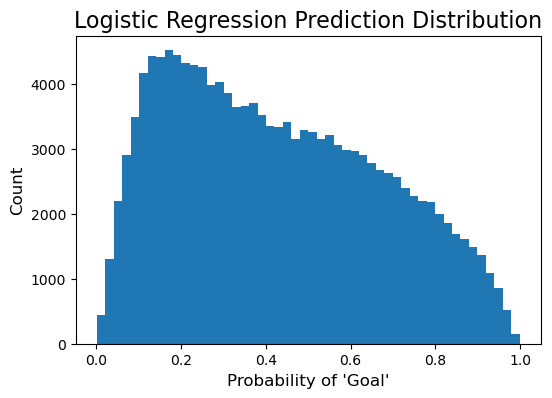

In [9]:
# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(d_logr['test_pred'], bins=50)
ax.set_title('Logistic Regression Prediction Distribution', fontsize=16)
ax.set_xlabel("Probability of 'Goal'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);


In [10]:
# Naive Bayes model
# https://scikit-learn.org/stable/modules/naive_bayes.html#
d_nbayes = {'name': 'Naive Bayes',
            'model': GaussianNB()}

# Train the models using k-fold cross-validation and a random parameter search
t_start = time()
d_nbayes['model'].fit(X_train, y_train)
d_nbayes['train_loss'] = log_loss(y_train, d_nbayes['model'].predict_proba(X_train)[:, 1])
d_nbayes['test_pred'] = d_nbayes['model'].predict_proba(X_test)[:, 1]
d_nbayes['test_loss'] = log_loss(y_test, d_nbayes['test_pred'])
pred_classes = np.round(d_nbayes['test_pred'], 0)
d_nbayes['test_acc'] = 100 * (pred_classes == y_test).sum() / y_test.size

t_full = time() - t_start
print(f'Took {timedelta(seconds=t_full)} to train the naive bayes model')

print(f"Trivial logloss for this problem: {dumb_loss:4.3f}")
print(f"Training logloss on the NB model: {d_nbayes['train_loss']:4.3f}")
print(f"Test logloss on the NB model: {d_nbayes['test_loss']:4.3f}")
print(f"Test accuracy on the NB model: {d_nbayes['test_acc']:4.2f}%")


Took 0:00:01.189698 to train the naive bayes model
Trivial logloss for this problem: 0.223
Training logloss on the NB model: 0.431
Test logloss on the NB model: 0.429
Test accuracy on the NB model: 91.38%


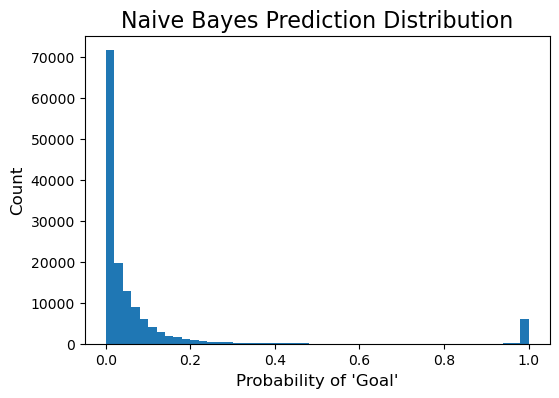

In [11]:
# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(d_nbayes['test_pred'], bins=50)
ax.set_title('Naive Bayes Prediction Distribution', fontsize=16)
ax.set_xlabel("Probability of 'Goal'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);


In [12]:
# XGBoost model
# https://xgboost.readthedocs.io/en/stable/python/python_api.html
d_xgb = {'name': 'XGBoost Classifier',
         'model': XGBClassifier(use_label_encoder=False, tree_method='hist'),
         'n_itr': 50,
         'params': {'n_estimators': [100, 200, 400],
                    'learning_rate': np.linspace(0., 0.9, 10),
                    'subsample': np.linspace(0.4, 1., 7),
                    'min_child_weight': [1, 5, 10, 20],
                    'max_leaves': [10, 20, 40, 80],
                    'max_depth': np.arange(2, 10),
                    'gamma': [1, 2, 4, 8]}}

# Train the models using k-fold cross-validation and a random parameter search
t_start = time()
# param_search = GridSearchCV(model['model'], model['params'], scoring='neg_log_loss', n_jobs=-1, cv=cv_split)
param_search = RandomizedSearchCV(d_xgb['model'], d_xgb['params'], n_iter=d_xgb['n_itr'], scoring='neg_log_loss', n_jobs=-1, cv=cv_split)
param_search.fit(X_train, y_train)
d_xgb['search_result'] = param_search
d_xgb['model'] = param_search.best_estimator_
d_xgb['train_loss'] = -param_search.best_score_

# Make predictions on the test set
d_xgb['test_pred'] = d_xgb['model'].predict_proba(X_test)[:, 1]
d_xgb['test_loss'] = log_loss(y_test, d_xgb['test_pred'])
pred_classes = np.round(d_xgb['test_pred'], 0)
d_xgb['test_acc'] = 100 * (pred_classes == y_test).sum() / y_test.size

t_full = time() - t_start
print(f'Took {timedelta(seconds=t_full)} to train the xgboost model')

print(f"Trivial logloss for this problem: {dumb_loss:4.3f}")
print(f"Training logloss on the XGB model: {d_xgb['train_loss']:4.3f}")
print(f"Test logloss on the XGB model: {d_xgb['test_loss']:4.3f}")
print(f"Test accuracy on the XGB model: {d_xgb['test_acc']:4.2f}%")


Took 0:31:46.905968 to train the xgboost model
Trivial logloss for this problem: 0.223
Training logloss on the XGB model: 0.172
Test logloss on the XGB model: 0.173
Test accuracy on the XGB model: 94.39%


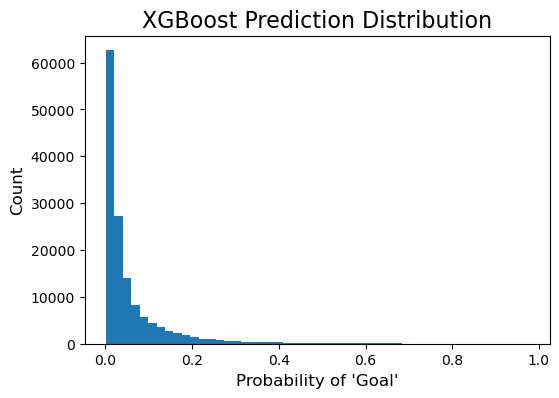

In [13]:
# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(d_xgb['test_pred'], bins=50)
ax.set_title('XGBoost Prediction Distribution', fontsize=16)
ax.set_xlabel("Probability of 'Goal'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);


In [14]:
import torch.nn as nn
from torch import optim, Tensor, sigmoid
from torch.utils.data import DataLoader


In [15]:
# Define hyperparameters
learning_rate = 1e-4
batch_size = 1024
n_epochs = 100
loss_fn = nn.BCEWithLogitsLoss()


Took 0:12:45.341412 to train the neural network
Trivial logloss for this problem: 0.223
Training logloss on the NN model: 0.178
Test logloss on the NN model: 0.179
Test accuracy on the NN model: 94.28%


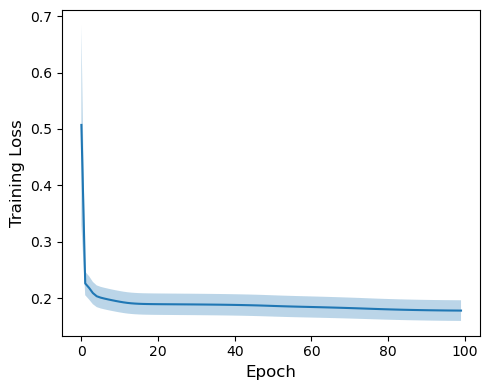

In [16]:
# Neural Network
d_nn = {'name': 'Neural Network',
        'model': RegressionNN(X_train.shape[-1], 16, 1).to('cpu').float()}

t_start = time()

# Define the training and test data loaders
train_data = CustomDataset(X_train, y_train)
test_data = CustomDataset(X_test, y_test)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Initialize a model and optimizer
# optimizer = optim.SGD(d_nn['model'].parameters(), lr=learning_rate)
optimizer = optim.Adam(d_nn['model'].parameters(), lr=learning_rate)

# Train the model
train_loss_avg = np.zeros(n_epochs)
train_loss_std = np.zeros(n_epochs)
t_start = time()
for t in range(n_epochs):
    epoch_loss = train_loop(train_dataloader, d_nn['model'], loss_fn, optimizer)
    train_loss_avg[t] = np.mean(epoch_loss)
    train_loss_std[t] = np.std(epoch_loss)

# Test the model
d_nn['train_pred'] = sigmoid(d_nn['model'](Tensor(X_train.astype(float)))).detach().numpy().squeeze()
d_nn['train_loss'] = log_loss(y_train, d_nn['train_pred'], eps=1e-7)
d_nn['test_pred'] = sigmoid(d_nn['model'](Tensor(X_test.astype(float)))).detach().numpy().squeeze()
d_nn['test_loss'] = log_loss(y_test, d_nn['test_pred'], eps=1e-7)
pred_classes = np.round(d_nn['test_pred'], 0)
d_nn['test_acc'] = 100 * (pred_classes == y_test).sum() / y_test.size

t_full = time() - t_start
print(f'Took {timedelta(seconds=t_full)} to train the neural network')

# Plot the progression of loss and accuracy
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(np.arange(n_epochs), train_loss_avg)
ax.fill_between(np.arange(n_epochs), train_loss_avg - train_loss_std, train_loss_avg + train_loss_std, alpha=0.3)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Training Loss', fontsize=12)
fig.tight_layout()

print(f"Trivial logloss for this problem: {dumb_loss:4.3f}")
print(f"Training logloss on the NN model: {d_nn['train_loss']:4.3f}")
print(f"Test logloss on the NN model: {d_nn['test_loss']:4.3f}")
print(f"Test accuracy on the NN model: {d_nn['test_acc']:4.2f}%")


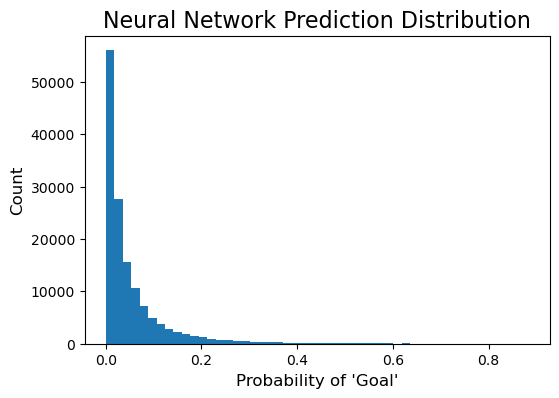

In [17]:
# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(d_nn['test_pred'], bins=50)
ax.set_title('Neural Network Prediction Distribution', fontsize=16)
ax.set_xlabel("Probability of 'Goal'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);


In [18]:
# List of all model classes
model_list = [d_logr, d_nbayes, d_xgb, d_nn]
n_models = len(model_list)
model_names = [model['name'] for model in model_list]


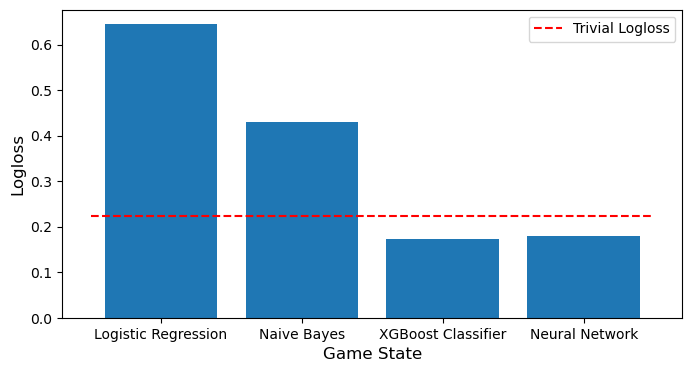

In [19]:
# Compare the model performances by logloss
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
width = 0.8
xs = np.arange(len(model_list)) + 0.5
# train_loss = [model['train_loss'] for model in models]
test_loss = [model['test_loss'] for model in model_list]
ax.bar(xs, test_loss, width=width)
ax.plot([0, len(model_list)], [dumb_loss, dumb_loss], 'r--', label='Trivial Logloss')
ax.set_xlabel('Game State', fontsize=12)
ax.set_xticks(xs)
ax.set_xticklabels(model_names, fontsize=10)
ax.set_ylabel('Logloss', fontsize=12)
# ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.02));
ax.legend(loc=1);


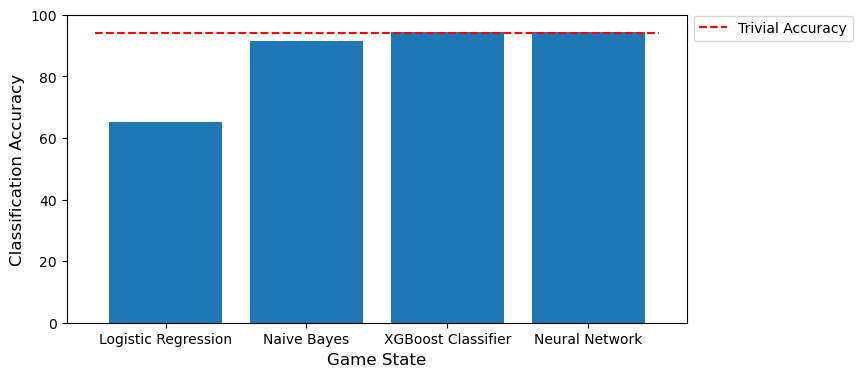

In [21]:
# Compare the model performances by logloss
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
test_acc = [model['test_acc'] for model in model_list]
f_class = 100 * (1 - p_goal)
ax.bar(xs, test_acc, width=width)
ax.plot([0, len(model_list)], [f_class, f_class], 'r--', label='Trivial Accuracy')
ax.set_xlabel('Game State', fontsize=12)
ax.set_ylim([0, 100])
ax.set_xticks(xs)
ax.set_xticklabels(model_names, fontsize=10)
ax.set_ylabel('Classification Accuracy', fontsize=12)
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.02));


/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/marshineer/Hockey-Analytics/models/common_plot.py:64: RuntimeWarning: invalid value encountered in long_scalars
  true_frac[j] = (y_true_bin == 1).sum() / y_true_bin.size


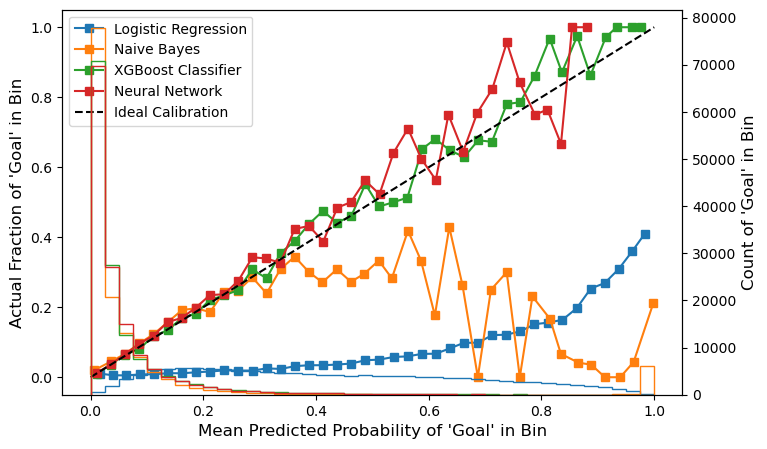

In [22]:
# Neural network calibration curves
test_preds = [model['test_pred'] for model in model_list]
test_ys = [y_test] * len(model_list)
mpl_objs = plot_calibration_curves(test_preds, test_ys, names=model_names,
                                   n_bins=40, avg_curve=False, class1='Goal')


# Calibrated Models

The expected goal distribution should reflect the actual number of goals scored. Calibration addresses this problem. If a model is well calibrated, the sum of its predicted goal probabilities will relfect the actual goal total. If additional factors are used to modify the xG predictions later, then these values should be subsequently calibrated to reflect the actual goal totals.

The calibration method used here is isontonic regression, either as a built-in sklearn function, or implemented using the sklearn IsotonicRegression class. Since the logistic regression and naive Bayes models are not well calibrated, it is reasonable to assume their performance will improve. On the other hand, it is not clear what effect calibration will have on the already reasonably calibrated models. 

The logistic regressor and naive Bayes models do show an improved logloss after calibration, although it is still below the performance of the XGBoost and neural network models. For these, calibration seems to result in over-fitting. This does not affect the performance and reduces the smoothness of the prediction distribution. Therefore, the models selected for the next step are the uncalibrated XGBoost and neural network.


In [23]:
# Logistic regression model calibration
t_start = time()
calibrate_obj = CalibratedClassifierCV(d_logr['model'], method='isotonic', cv='prefit', n_jobs=-1)
calibrate_obj.fit(X_valid, y_valid)
d_logr['calibrated_model'] = calibrate_obj

# Make calibrated predictions on the test set
d_logr['test_pred_cal'] = d_logr['calibrated_model'].predict_proba(X_test)[:, 1]
d_logr['test_loss_cal'] = log_loss(y_test, d_logr['test_pred_cal'])
valid_classes = np.round(d_logr['test_pred_cal'], 0)
d_logr['test_acc_cal'] = 100 * (valid_classes == y_test).sum() / y_test.size

t_full = time() - t_start
print(f'Took {timedelta(seconds=t_full)} to calibrate the logistic regression model')

print(f"Trivial logloss for this problem: {dumb_loss:4.3f}")
print(f"Test logloss on the Logit model: {d_logr['test_loss_cal']:4.3f}")
print(f"Test accuracy on the Logit model: {d_logr['test_acc_cal']:4.2f}%")


Took 0:00:00.193252 to calibrate the logistic regression model
Trivial logloss for this problem: 0.223
Test logloss on the Logit model: 0.194
Test accuracy on the Logit model: 94.11%


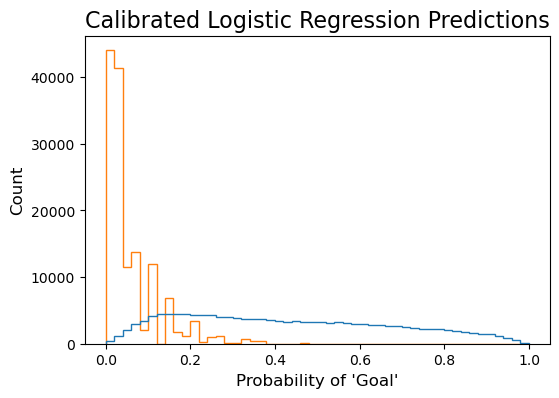

In [24]:
# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist([d_logr['test_pred'], d_logr['test_pred_cal']], histtype='step', bins=50)
ax.set_title('Calibrated Logistic Regression Predictions', fontsize=16)
ax.set_xlabel("Probability of 'Goal'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);


In [25]:
# Naive Bayes model calibration
t_start = time()
calibrate_obj = CalibratedClassifierCV(d_nbayes['model'], method='isotonic', cv='prefit', n_jobs=-1)
calibrate_obj.fit(X_valid, y_valid)
d_nbayes['calibrated_model'] = calibrate_obj

# Make calibrated predictions on the test set
d_nbayes['test_pred_cal'] = d_nbayes['calibrated_model'].predict_proba(X_test)[:, 1]
d_nbayes['test_loss_cal'] = log_loss(y_test, d_nbayes['test_pred_cal'])
valid_classes = np.round(d_nbayes['test_pred_cal'], 0)
d_nbayes['test_acc_cal'] = 100 * (valid_classes == y_test).sum() / y_test.size

t_full = time() - t_start
print(f'Took {timedelta(seconds=t_full)} to calibrate the naive bayes model')

print(f"Trivial logloss for this problem: {dumb_loss:4.3f}")
print(f"Test logloss on the NB model: {d_nbayes['test_loss_cal']:4.3f}")
print(f"Test accuracy on the NB model: {d_nbayes['test_acc_cal']:4.2f}%")


Took 0:00:00.237599 to calibrate the naive bayes model
Trivial logloss for this problem: 0.223
Test logloss on the NB model: 0.196
Test accuracy on the NB model: 94.11%


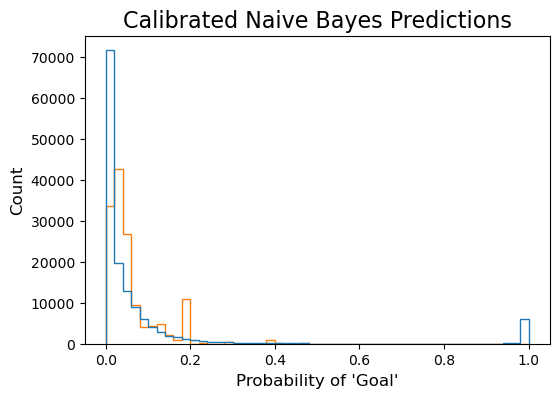

In [26]:
# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist([d_nbayes['test_pred'], d_nbayes['test_pred_cal']], histtype='step', bins=50)
ax.set_title('Calibrated Naive Bayes Predictions', fontsize=16)
ax.set_xlabel("Probability of 'Goal'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);


In [27]:
# XGBoost model calibration
t_start = time()
calibrate_obj = CalibratedClassifierCV(d_xgb['model'], method='isotonic', cv='prefit', n_jobs=-1)
calibrate_obj.fit(X_valid, y_valid)
d_xgb['calibrated_model'] = calibrate_obj

# Make calibrated predictions on the test set
d_xgb['test_pred_cal'] = d_xgb['calibrated_model'].predict_proba(X_test)[:, 1]
d_xgb['test_loss_cal'] = log_loss(y_test, d_xgb['test_pred_cal'])
valid_classes = np.round(d_xgb['test_pred_cal'], 0)
d_xgb['test_acc_cal'] = 100 * (valid_classes == y_test).sum() / y_test.size

t_full = time() - t_start
print(f'Took {timedelta(seconds=t_full)} to calibrate the XGBoost model')

print(f"Trivial logloss for this problem: {dumb_loss:4.3f}")
print(f"Test logloss on the XGB model: {d_xgb['test_loss_cal']:4.3f}")
print(f"Test accuracy on the XGB model: {d_xgb['test_acc_cal']:4.2f}%")


Took 0:00:00.415678 to calibrate the XGBoost model
Trivial logloss for this problem: 0.223
Test logloss on the XGB model: 0.174
Test accuracy on the XGB model: 94.40%


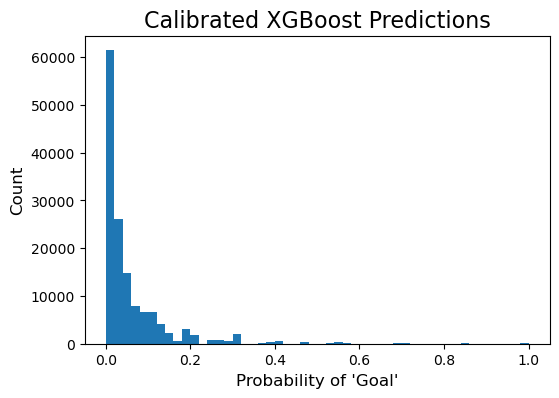

In [28]:
# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(d_xgb['test_pred_cal'], bins=50)
ax.set_title('Calibrated XGBoost Predictions', fontsize=16)
ax.set_xlabel("Probability of 'Goal'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);


In [29]:
# Neural network model calibration
t_start = time()
calibrate_obj = IsotonicRegression(y_min=0, y_max=1, increasing='auto', out_of_bounds='clip')
d_nn['valid_pred'] = sigmoid(d_nn['model'](Tensor(X_valid.astype(float)))).detach().numpy().squeeze()

# Make calibrated predictions on the test set
calibrate_obj.fit(d_nn['valid_pred'], y_valid)
d_nn['test_pred_cal'] = calibrate_obj.predict(d_nn['test_pred'])
d_nn['test_loss_cal'] = log_loss(y_test, d_nn['test_pred_cal'])
valid_classes = np.round(d_nn['test_pred_cal'], 0)
d_nn['test_acc_cal'] = 100 * (valid_classes == y_test).sum() / y_test.size

t_full = time() - t_start
print(f'Took {timedelta(seconds=t_full)} to calibrate the neural network model')

print(f"Trivial logloss for this problem: {dumb_loss:4.3f}")
print(f"Test logloss on the NN model: {d_nn['test_loss_cal']:4.3f}")
print(f"Test accuracy on the NN model: {d_nn['test_acc_cal']:4.2f}%")


Took 0:00:00.194532 to calibrate the neural network model
Trivial logloss for this problem: 0.223
Test logloss on the NN model:  nan
Test accuracy on the NN model: 94.30%


/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2465: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2465: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


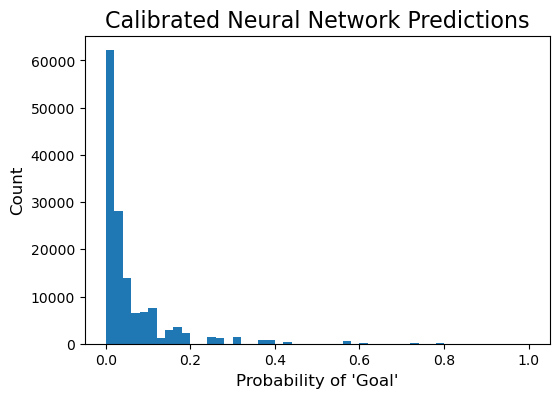

In [30]:
# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(d_nn['test_pred_cal'], bins=50)
ax.set_title('Calibrated Neural Network Predictions', fontsize=16)
ax.set_xlabel("Probability of 'Goal'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);


/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/marshineer/Hockey-Analytics/models/common_plot.py:64: RuntimeWarning: invalid value encountered in long_scalars
  true_frac[j] = (y_true_bin == 1).sum() / y_true_bin.size
/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


[96843 22617 13342  5087  2334   757   912     0   117     9]
[102435  18642   7210  11581    306    473   1013     64    276     18]
[116787  16483   3881   2636    783    697    254    220    197     80]
[117440  17583   2612   3002    384    476    210    307      0      4]


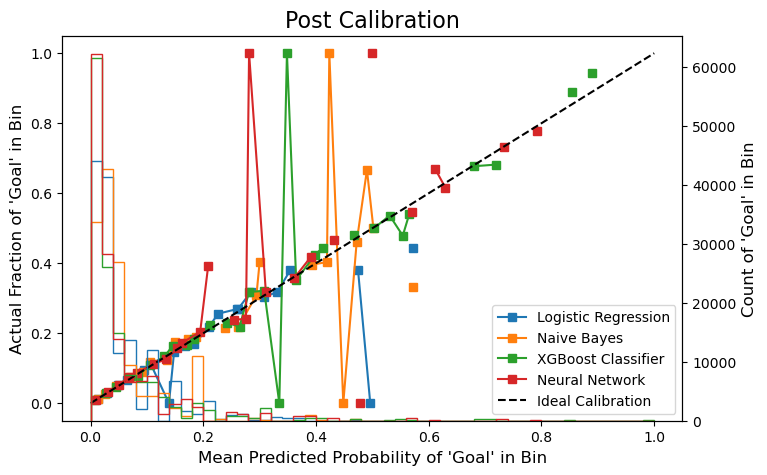

In [31]:
# Neural network calibration curves
test_preds = [model['test_pred_cal'] for model in model_list]
test_ys = [y_test] * len(model_list)
mpl_objs = plot_calibration_curves(test_preds, test_ys, names=model_names,
                                   n_bins=50, avg_curve=False, class1='Goal',
                                   plt_ttl='Post Calibration')
for yhats in test_preds:
    counts, _ = np.histogram(yhats)
    print(counts)


# Feature Importance and Reduction

There are various feature scoring functions available for sklearn's SelectKBest class. They each evaluate similar features as the most important, with mutual information differing slightly from ANOVA and $chi^2$. Furthermore, these features agree with the features that were most important in training the XGBoost model.

In order to determine whether a the models can achieve a similar performance using fewer features, the XGBoost and neural network models are trained with a subset of features.


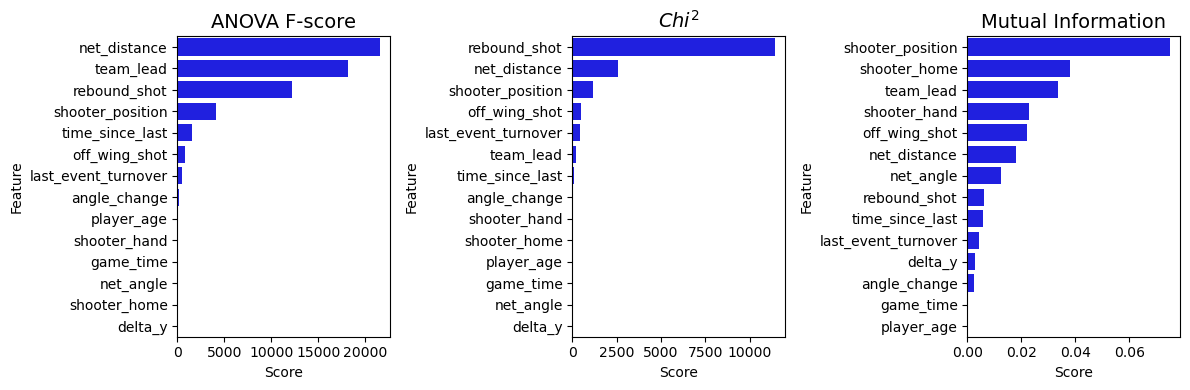

In [32]:
# Score the features using cross-correlation-based f-scoring
score_methods = [f_classif, chi2, mutual_info_classif]
score_names = ['ANOVA F-score', r'$Chi^2$', 'Mutual Information']
fig, axes = plt.subplots(1, len(score_methods), figsize=(12, 4))
for i, (method, name) in enumerate(zip(score_methods, score_names)):
    feature_eval = SelectKBest(score_func=method, k='all')
    fit = feature_eval.fit(X_train, y_train)
    best_scores = pd.DataFrame(fit.scores_)
    feat_list = pd.DataFrame(data_df.columns[:-1])

    select_feats = pd.concat([feat_list, best_scores], axis=1)
    select_feats.columns = ['Feature', 'Score']
    sorted_scores = select_feats.sort_values(['Score'])
    sorted_feats = sorted_scores['Feature'][:-1]
    
    sns.barplot(x="Score", y="Feature", data=sorted_scores[::-1], color="b", ax=axes[i])
    axes[i].set_title(score_names[i], fontsize=14)
fig.tight_layout();


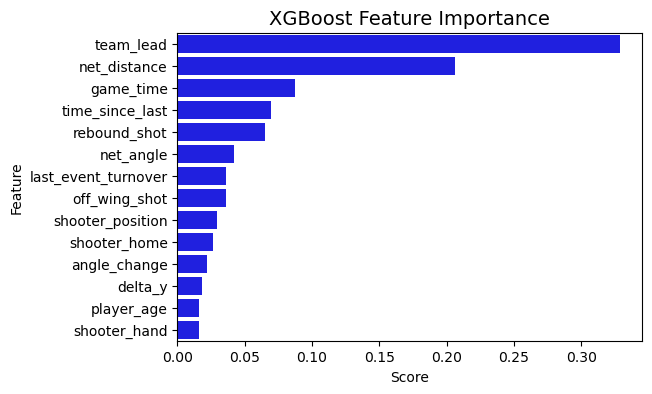

In [33]:
# Get feature importances from trained XGBoost model
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
best_scores = pd.DataFrame(d_xgb['model'].feature_importances_)
feat_list = pd.DataFrame(data_df.columns[:-1])

select_feats = pd.concat([feat_list, best_scores], axis=1)
select_feats.columns = ['Feature', 'Score']
sorted_scores = select_feats.sort_values(['Score'])
sorted_feats = sorted_scores['Feature'][:-1]

sns.barplot(x="Score", y="Feature", data=sorted_scores[::-1], color="b", ax=ax)
ax.set_title('XGBoost Feature Importance', fontsize=14);


In [35]:
# Reduce the number of features to a subset
# feature_subset = ['net_distance', 'net_angle', 'time_since_last', 'game_time',
#                   'team_lead', 'rebound_shot', 'shooter_position', 'off_wing_shot',
#                   'last_event_turnover', 'last_event_shot', 'goal']
# feature_subset = ['net_distance', 'net_angle', 'delta_y', 'angle_change',
#                   'time_since_last', 'game_time', 'team_lead', 'rebound_shot',
#                   'shooter_position', 'off_wing_shot', 'last_event_turnover',
#                   'last_event_shot', 'goal']
# feature_subset = ['x_coord', 'y_coord', 'last_x_coord', 'last_y_coord',
#                   'time_since_last', 'game_time', 'team_lead', 'rebound_shot',
#                   'shooter_position', 'off_wing_shot', 'last_event_turnover',
#                   'last_event_shot', 'goal']
feature_subset = ['net_distance', 'net_angle', 'delta_y', 'angle_change',
                  'time_since_last', 'game_time', 'team_lead', 'rebound_shot',
                  'shooter_position', 'off_wing_shot', 'last_event_turnover',
                  'goal']
data_df_sub = data_df[feature_subset]

# Split the data into stratified training and test sets
X_pd, y_pd = data_df_sub.iloc[:, :-1].values, data_df_sub.iloc[:, -1].values
tmp_split = train_test_split(X_pd, y_pd, test_size=0.3, random_state=66,
                             stratify=y_pd)
X_train_sub, X_temp, y_train_sub, y_temp = tmp_split
tmp_split = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)
X_valid_sub, X_test_sub, y_valid_sub, y_test_sub = tmp_split

# Scale the data
x_scaler_sub = MinMaxScaler()
X_train_norm = x_scaler_sub.fit_transform(X_train_sub[:, :7])
X_train_sub[:, :7] = X_train_norm.squeeze()
X_valid_norm = x_scaler_sub.transform(X_valid_sub[:, :7])
X_valid_sub[:, :7] = X_valid_norm.squeeze()
X_test_norm = x_scaler_sub.transform(X_test_sub[:, :7])
X_test_sub[:, :7] = X_test_norm.squeeze()
    

In [36]:
# XGBoost model
# https://xgboost.readthedocs.io/en/stable/python/python_api.html
d_xgb_sub = {'name': 'XGBoost Classifier Reduced',
             'model': XGBClassifier(use_label_encoder=False, tree_method='hist'),
             'n_itr': 50,
             'params': {'n_estimators': [100, 200, 400, 800],
                        'learning_rate': np.linspace(0.1, 0.9, 9),
                        'subsample': np.linspace(0.4, 1., 7),
                        'min_child_weight': [1, 5, 10, 20],
                        'max_leaves': [10, 20, 40, 80],
                        'max_depth': np.arange(2, 10),
                        'gamma': [1, 2, 4, 8]}}

# Train the models using k-fold cross-validation and a random parameter search
t_start = time()
# param_search = GridSearchCV(model['model'], model['params'], scoring='neg_log_loss', n_jobs=-1, cv=cv_split)
param_search = RandomizedSearchCV(d_xgb_sub['model'], d_xgb_sub['params'], n_iter=d_xgb_sub['n_itr'], scoring='neg_log_loss', n_jobs=-1, cv=cv_split)
param_search.fit(X_train_sub, y_train_sub)
d_xgb_sub['search_result'] = param_search
d_xgb_sub['model'] = param_search.best_estimator_
d_xgb_sub['train_loss'] = -param_search.best_score_

# Make predictions on the test set
d_xgb_sub['test_pred'] = d_xgb_sub['model'].predict_proba(X_test_sub)[:, 1]
d_xgb_sub['test_loss'] = log_loss(y_test_sub, d_xgb_sub['test_pred'])
pred_classes = np.round(d_xgb_sub['test_pred'], 0)
d_xgb_sub['test_acc'] = 100 * (pred_classes == y_test_sub).sum() / y_test_sub.size

t_full = time() - t_start
print(f'Took {timedelta(seconds=t_full)} to train the xgboost model')

print(f"Trivial logloss for this problem: {dumb_loss:4.3f}")
print(f"Training logloss on the XGB model: {d_xgb_sub['train_loss']:4.3f}")
print(f"Test logloss on the XGB model: {d_xgb_sub['test_loss']:4.3f}")
print(f"Test accuracy on the XGB model: {d_xgb_sub['test_acc']:4.2f}%")


/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2465: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2465: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [-0.17380116 -0.2003101  -0.17298469 -0.17228193 -0.17236332 -0.17463757
 -0.17237362 -0.17630058 -0.17375178 -0.17601946 -0.17188956 -0.17240634
 -0.17263624 -0.17243412 -0.17336498 -0.17346826 -0.17244031 -0.17420447
 -0.1734871  -0.17486079 -0.19204394 -0.17236549 -0.20705462 -0.17221395
 -0.17298357 -0.17201527 -0.17257059 -0.17265576 -0.17430582 -0.17285973
 -0.17228322 -0.17196383 

Took 0:23:22.258769 to train the xgboost model
Trivial logloss for this problem: 0.223
Training logloss on the XGB model: 0.172
Test logloss on the XGB model: 0.173
Test accuracy on the XGB model: 94.40%


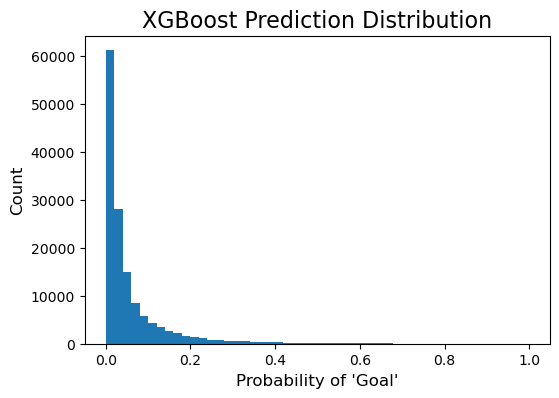

In [37]:
# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(d_xgb_sub['test_pred'], bins=50)
ax.set_title('XGBoost Prediction Distribution', fontsize=16)
ax.set_xlabel("Probability of 'Goal'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);


Took 0:12:35.005766 to train the neural network
Trivial logloss for this problem: 0.223
Training logloss on the NN model: 0.178
Test logloss on the NN model: 0.179
Test accuracy on the NN model: 94.28%


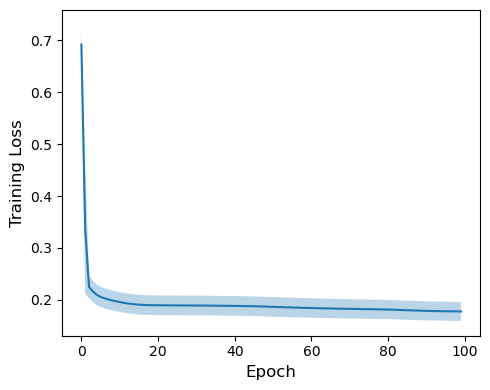

In [38]:
# Neural Network
d_nn_sub = {'name': 'Neural Network Reduced',
            'model': RegressionNN(X_train_sub.shape[-1], 16, 1).to('cpu').float()}

# Define the training and test data loaders
train_data = CustomDataset(X_train_sub, y_train_sub)
test_data = CustomDataset(X_test_sub, y_test_sub)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Initialize a model and optimizer
# optimizer = optim.SGD(d_nn_sub['model'].parameters(), lr=learning_rate)
optimizer = optim.Adam(d_nn_sub['model'].parameters(), lr=learning_rate)

# Train the model
t_start = time()
train_loss_avg = np.zeros(n_epochs)
train_loss_std = np.zeros(n_epochs)
t_start = time()
for t in range(n_epochs):
    epoch_loss = train_loop(train_dataloader, d_nn_sub['model'], loss_fn, optimizer)
    train_loss_avg[t] = np.mean(epoch_loss)
    train_loss_std[t] = np.std(epoch_loss)

# Test the model
d_nn_sub['train_pred'] = sigmoid(d_nn_sub['model'](Tensor(X_train_sub.astype(float)))).detach().numpy().squeeze()
d_nn_sub['train_loss'] = log_loss(y_train_sub, d_nn_sub['train_pred'], eps=1e-7)
d_nn_sub['test_pred'] = sigmoid(d_nn_sub['model'](Tensor(X_test_sub.astype(float)))).detach().numpy().squeeze()
d_nn_sub['test_loss'] = log_loss(y_test_sub, d_nn_sub['test_pred'], eps=1e-7)
pred_classes = np.round(d_nn_sub['test_pred'], 0)
d_nn_sub['test_acc'] = 100 * (pred_classes == y_test_sub).sum() / y_test_sub.size

t_full = time() - t_start
print(f'Took {timedelta(seconds=t_full)} to train the neural network')

# Plot the progression of loss and accuracy
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(np.arange(n_epochs), train_loss_avg)
ax.fill_between(np.arange(n_epochs), train_loss_avg - train_loss_std, train_loss_avg + train_loss_std, alpha=0.3)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Training Loss', fontsize=12)
fig.tight_layout()

print(f"Trivial logloss for this problem: {dumb_loss:4.3f}")
print(f"Training logloss on the NN model: {d_nn['train_loss']:4.3f}")
print(f"Test logloss on the NN model: {d_nn['test_loss']:4.3f}")
print(f"Test accuracy on the NN model: {d_nn['test_acc']:4.2f}%")


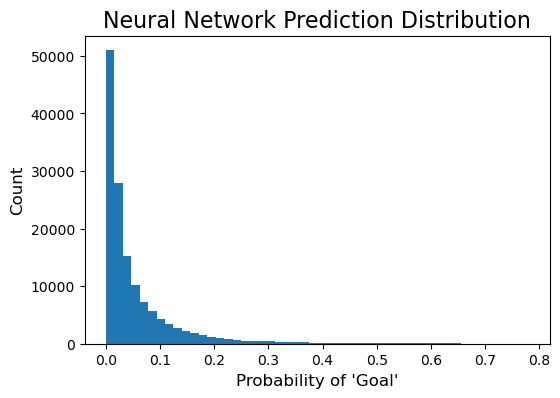

In [39]:
# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(d_nn_sub['test_pred'], bins=50)
ax.set_title('Neural Network Prediction Distribution', fontsize=16)
ax.set_xlabel("Probability of 'Goal'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);


/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/marshineer/Hockey-Analytics/models/common_plot.py:64: RuntimeWarning: invalid value encountered in long_scalars
  true_frac[j] = (y_true_bin == 1).sum() / y_true_bin.size


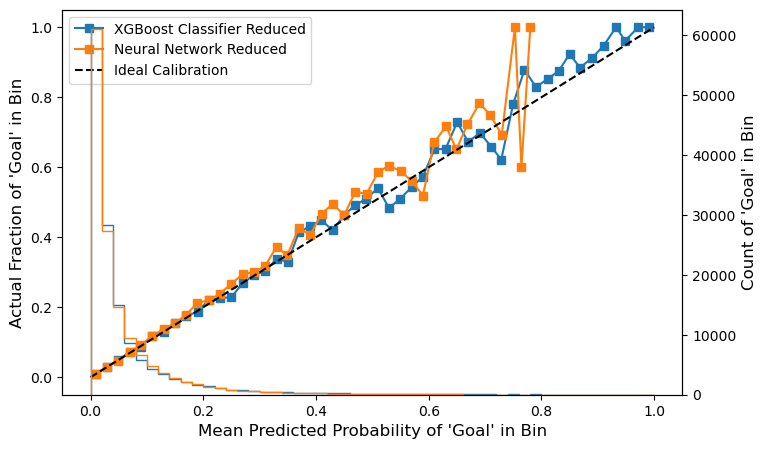

In [40]:
# Neural network calibration curves
subset_models = [d_xgb_sub, d_nn_sub]
test_preds = [model['test_pred'] for model in subset_models]
subset_names = [model['name'] for model in subset_models]
test_ys = [y_test] * len(subset_models)
mpl_objs = plot_calibration_curves(test_preds, test_ys, names=subset_names,
                                   n_bins=50, avg_curve=False, class1='Goal')


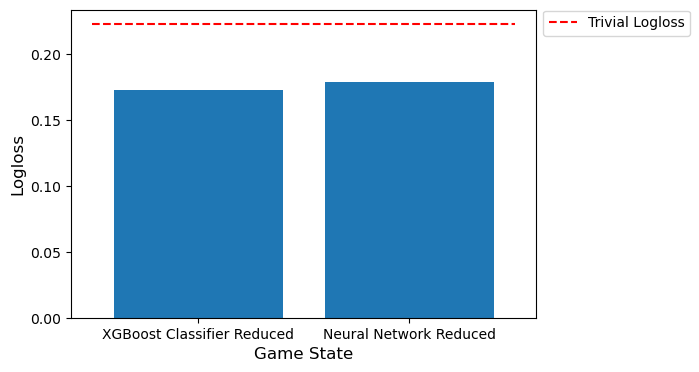

In [41]:
# Compare the model performances by logloss
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
width = 0.8
xs = np.arange(len(subset_models)) + 0.5
test_loss = [model['test_loss'] for model in subset_models]
ax.bar(xs, test_loss, width=width)
ax.plot([0, len(subset_models)], [dumb_loss, dumb_loss], 'r--', label='Trivial Logloss')
ax.set_xlabel('Game State', fontsize=12)
ax.set_xticks(xs)
ax.set_xticklabels(subset_names, fontsize=10)
ax.set_ylabel('Logloss', fontsize=12)
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.02));
# ax.legend(loc=1);


In [42]:
# Determine hyperparameters
xgb_results = pd.DataFrame(d_xgb_sub['search_result'].cv_results_)
xgb_results.sort_values('rank_test_score', inplace=True)
xgb_results.reset_index(drop=True, inplace=True)
# print(xgb_results.columns.tolist())
result_cols = ['param_subsample', 'param_n_estimators',
               'param_min_child_weight', 'param_max_leaves',
               'param_max_depth', 'param_learning_rate',
               'param_gamma', 'params', 'mean_test_score',
               'std_test_score', 'rank_test_score']
xgb_results = xgb_results[result_cols]
new_result_cols = ['subsample', 'n_estimators', 'min_child_weight', 'max_leaves',
                   'max_depth', 'learning_rate', 'gamma', 'params',
                   'mean_test_score', 'std_test_score', 'rank_test_score']
xgb_results.columns = new_result_cols
# display(xgb_results)
print(f'The average cross-validation negative Logloss is '
      f'{np.mean(xgb_results.mean_test_score):4.3f} +/- '
      f'{np.std(xgb_results.mean_test_score):4.3f}')


The average cross-validation negative Logloss is -0.176 +/- 0.009


In [43]:
display(xgb_results)


,subsample,n_estimators,min_child_weight,max_leaves,max_depth,learning_rate,gamma,params,mean_test_score,std_test_score,rank_test_score
0,0.9,400,1,40,3,0.1,2,"{'subsample': 0.8999999999999999, 'n_estimator...",-0.171890,0.001196,1
1,0.8,800,1,10,2,0.2,1,"{'subsample': 0.8, 'n_estimators': 800, 'min_c...",-0.171964,0.001174,2
2,1.0,200,5,10,5,0.4,1,"{'subsample': 1.0, 'n_estimators': 200, 'min_c...",-0.172015,0.001236,3
3,0.5,200,20,80,3,0.3,1,"{'subsample': 0.5, 'n_estimators': 200, 'min_c...",-0.172214,0.001196,4
4,0.6,800,5,80,5,0.3,8,"{'subsample': 0.6, 'n_estimators': 800, 'min_c...",-0.172251,0.001254,5
5,0.9,100,1,40,9,0.1,1,"{'subsample': 0.8999999999999999, 'n_estimator...",-0.172282,0.001211,6
6,0.4,200,20,80,3,0.2,4,"{'subsample': 0.4, 'n_estimators': 200, 'min_c...",-0.172283,0.001299,7
7,1.0,200,5,20,5,0.2,2,"{'subsample': 1.0, 'n_estimators': 200, 'min_c...",-0.172332,0.001276,8
8,0.5,100,10,80,6,0.2,1,"{'subsample': 0.5, 'n_estimators': 100, 'min_c...",-0.172363,0.001202,9
9,0.4,400,20,20,5,0.2,8,"{'subsample': 0.4, 'n_estimators': 400, 'min_c...",-0.172365,0.001255,10
